# Keras Image Classification

Eperimenting some simple image classification using VGG16. We want to classify the content of the image based on the type of photo.

In [31]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [32]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import numpy as np

Load Resenet Model, without last fully connected layer

In [104]:
HEIGHT = 224
WIDTH = 224
batch_size = 8
TRAIN_DIR = './data/dataset_automobili/'

base_model = VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

Preprocess input data

In [105]:

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split=0.2) # set validation split


Prepare training data, and resize the source images

In [106]:

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=batch_size,
                                                   subset='training')

validation_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=batch_size,
                                                   subset='validation')

Found 2557 images belonging to 16 classes.
Found 631 images belonging to 16 classes.


View the generated Images

{0: 'altro', 1: 'anteriore', 2: 'anteriore_dx', 3: 'anteriore_sx', 4: 'bagaglio', 5: 'cruscotto', 6: 'lato_dx', 7: 'lato_sx', 8: 'moto', 9: 'motore', 10: 'posteriore', 11: 'posteriore_dx', 12: 'posteriore_sx', 13: 'ruote', 14: 'sedili', 15: 'strumenti'}


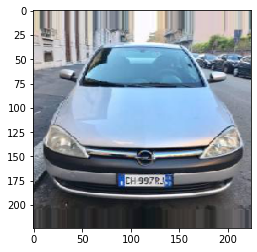

Class = anteriore


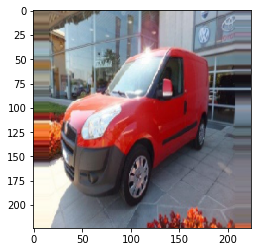

Class = anteriore_sx


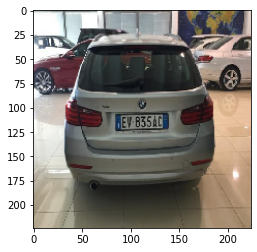

Class = posteriore


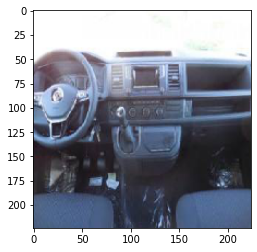

Class = cruscotto


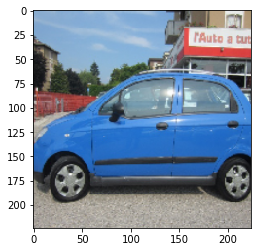

Class = lato_sx


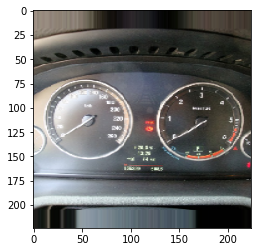

Class = cruscotto


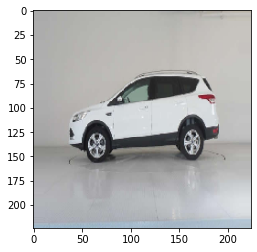

Class = lato_sx


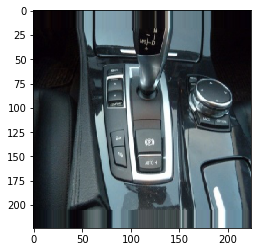

Class = strumenti


In [99]:
import matplotlib.pyplot as plt
import keras.backend

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print (labels)

x_batch, y_batch = next(train_generator)
for i in range (0,8):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()
    #print ("Y={0}".format(y_batch[i]))
    predicted_class=np.argmax(y_batch[i],axis=0)
    print 
    print ("Class = {0}".format(labels[predicted_class]))

We start by freezing all of the base model’s layers. We don’t want to train those layers since we are trying to leverage the knowledge learned by the network from the previous dataset (in this case ImageNet). By setting the layer.trainable=False , we are telling Keras not to update those weights during training, which is exactly what we want!

Now we can add on our FC layers. We do this in a loop since many networks have multiple FC layers and looping through a list makes things clean and easy. We’ll also add in some dropout to each FC layer to reduce the chances of overfitting (this part is optional). At the end, we tack on the final Softmax layer and build the Keras model.
Once our function is all set up, it’s a simple one-liner to create our final model. Just pass over the number of classes for the softmax layer, the sizes of the FC layers in a list (since we loop over it), and the dropout probability.

In [107]:
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model

def build_finetune_model(base_model, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x) 
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x) 
    x = Dropout(0.5)(x)
    
    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

## Training
We’ll use the Adam optimiser with a small value for the learning rate. We choose Adam because it’s super quick and easy to use vs SGD. We set the learning rate to be small because we are only fine tuning our model here, specifically the FC layers; we aren’t looking for any massive changes, just tweaks.

We’ll also set up some checkpoints to save the weights for later. Applying the fit_generator functions runs the entire training regiment with optional number of epochs, batch size, and data shuffling. Once the training is all done, we can use the history output to plot our training results.

In [108]:
model = build_finetune_model(base_model, 16)

In [109]:
from keras.optimizers import SGD, Adam
model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs = 3,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size
)

Epoch 1/3
144/319 [============>.................] - ETA: 10:58 - loss: 2.9505 - acc: 0.1016

In [77]:
model.save('checkpoints/train_only_top.h5')

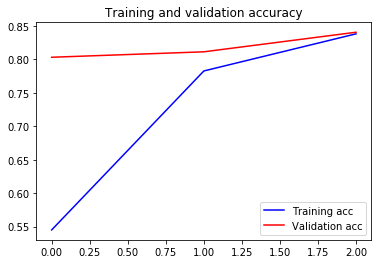

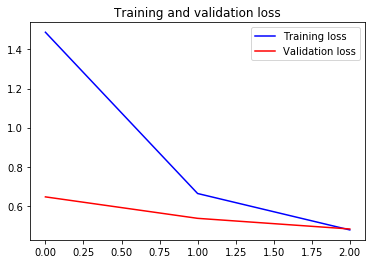

In [78]:
acc = fit_history.history['acc']
val_acc = fit_history.history['val_acc']
loss = fit_history.history['loss']
val_loss = fit_history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Make last block of the conv_base trainable:

In [23]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________